**Goal**: See if causal impact could be a useful (and valid) method 
to measure the impact of a product feature on users.

Look at the case of personalized browse, which launched to 100% of users on 2020-04-28.

Compare browse mw and browse mw from recs to direct-to-channel mw.

Use this [python package](http://jamalsenouci.github.io/projects/causalimpact.html).

# Start with Android Prowse AB

In [1]:
from causalimpact import CausalImpact
import numpy as np
import pandas as pd
import os
import logging
from statsmodels.tsa.arima_process import arma_generate_sample
import matplotlib
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (15, 6)

In [3]:
# android prowse on `enabled` group
EXP_DATA = {
    'window_length': 60,          
    'launch_date': '2019-12-09',  
}

def fetch_data_android(save_locally=True, local_filename='mw_android_prowse.csv'):
    """ Issue SQL and return a pandas df. 
    Read from csv if result is cached locally in that csv. 
    """
    
    if os.path.exists(local_filename):
        df = pd.read_csv(local_filename)
        return df
    
    host = 'localhost' # if bastion, just use whatever is in your ~/.pgpass
    port = '5439'
    db = 'product'
    user = ''
    conn = pg.connect(host=host,port=port,database=db,user=user)
    
    launch_date = EXP_DATA['launch_date']
    window_length = EXP_DATA['window_length']

    sql = f"""
-- android_prowse_v2, enrolls device_ids
-- 9/30 to 12/9, ONLY FOR USERS ENROLLED IN BOTH PHASES
-- compare mw/user for group=enabled, launch date is 2019-12-09


with enrollment_preagg_pre_period as (
select
  device_id,
  min(experiment_group) as experiment_group
from cubes.expo_eb_preagg
where date >= '{launch_date}'::timestamp - interval '{window_length} days'
  and date < '{launch_date}'::timestamp 
  and experiment_id = 'd364f0cb-8233-4557-a16f-23e40508f6e9' 
  and device_id is not null
  and user_id is not null
  and app_version >= '8.1.0'
  and experiment_version in (8216,8035,7832)
  and experiment_group in ('enabled','control') -- 50 default_on - 45 enabled - 5 control
group by 1
having min(experiment_group) = max(experiment_group) -- no flickers
)

,enrollment_preagg_post_period as (
select
  device_id,
  min(experiment_group) as experiment_group
from cubes.expo_eb_preagg
where date >= '{launch_date}'::timestamp
  and date < '{launch_date}'::timestamp + interval '{window_length} days' 
  and experiment_id = 'd364f0cb-8233-4557-a16f-23e40508f6e9' 
  and device_id is not null
  and user_id is not null
  and app_version >= '8.1.0'
  and experiment_version = 8852
  and experiment_group in ('default_on','control') -- 95 default_on - 5 control
group by 1
having min(experiment_group) = max(experiment_group) -- no flickers
)

, enrollment as (
-- keep only devices who show up in both time frames, so we have only the intervened group
select
  a.device_id,
  min(a.experiment_group) as experiment_group -- technically, switched from a.grp to b.grp, but whatever
from enrollment_preagg_pre_period a
join enrollment_preagg_post_period b
  on a.device_id = b.device_id
group by 1
)

, sitewide_playback_android as (
select
  device_id,
  day as dt,
  sum(video_plays) as vp,
  sum(hours_watched) as hw,
  sum(five_minute_plays) as fmp
from warehouse.fact_viewer_activity_daily
where day >= '{launch_date}'::timestamp - interval '{window_length} days' 
  and day < '{launch_date}'::timestamp + interval '{window_length} days' 
  and device_id is not null
  and user_id is not null
  and viewer_platform = 'android'
group by 1,2
)

, browse_playback_android as (
select 
  device_id,
  dt as dt,
  sum(fmp) as browse_fmp,
  sum(vp) as browse_vp,
  sum(mw)::float / 60 as browse_hw
from cubes.daily_recs_video_metrics
where dt >= '{launch_date}'::timestamp - interval '{window_length} days'
  and dt < '{launch_date}'::timestamp + interval '{window_length} days'
  and classification = 'internal'
  and is_holdout = False
  and platform = 'android'
  and user_id is not null
  and device_id is not null
group by 1,2
)

select
  nvl(p.dt,b.dt) as dt,
  
  sum(case when experiment_group = 'control' then 1 else 0 end) as n_users_control,
  sum(case when experiment_group = 'enabled' then 1 else 0 end) as n_users_enabled,
  
  sum(case when experiment_group = 'control' then vp else 0 end) as vp_control,
  sum(case when experiment_group = 'enabled' then vp else 0 end) as vp_enabled,
  
  sum(case when experiment_group = 'control' then hw else 0 end) as hw_control,
  sum(case when experiment_group = 'enabled' then hw else 0 end) as hw_enabled,
  
  sum(case when experiment_group = 'control' then fmp else 0 end) as fmp_control,
  sum(case when experiment_group = 'enabled' then fmp else 0 end) as fmp_enabled,
  
  sum(case when experiment_group = 'control' then browse_vp else 0 end) as browse_vp_control,
  sum(case when experiment_group = 'enabled' then browse_vp else 0 end) as browse_vp_enabled,
  
  sum(case when experiment_group = 'control' then browse_hw else 0 end) as browse_hw_control,
  sum(case when experiment_group = 'enabled' then browse_hw else 0 end) as browse_hw_enabled,
  
  sum(case when experiment_group = 'control' then browse_fmp else 0 end) as browse_fmp_control,
  sum(case when experiment_group = 'enabled' then browse_fmp else 0 end) as browse_fmp_enabled
  
from enrollment e
left join sitewide_playback_android p
  on p.device_id = e.device_id
left join browse_playback_android b
  on b.device_id = e.device_id
  and b.dt = p.dt
group by 1
order by 1
    """
    
#    df = pd.read_sql(sql, conn)
#    conn.close()
    
#    if save_locally:
#        df.to_csv(local_filename)
        
#    return df

mw_df = pd.read_csv('mw_android_prowse.csv', index_col=0)
mw_df.head()

,dt,n_users_control,n_users_enabled,vp_control,vp_enabled,hw_control,hw_enabled,fmp_control,fmp_enabled,browse_vp_control,browse_vp_enabled,browse_hw_control,browse_hw_enabled,browse_fmp_control,browse_fmp_enabled
0,2019-10-10,87093,780686,418419,3752816,78697.5085,7.045771e+05,139583,1247996,389986,3491838,75312.283333,6.732889e+05,138027,1231764
1,2019-10-11,88421,790446,424759,3776985,78245.4649,6.966801e+05,136111,1209291,396005,3513540,75394.166667,6.701509e+05,134463,1193403
2,2019-10-12,95586,854118,503954,4478184,92486.6223,8.200229e+05,160779,1423611,468189,4154893,88845.716667,7.867722e+05,159002,1407365
3,2019-10-13,117208,1049529,931139,8301937,123665.0631,1.097786e+06,238853,2124715,878988,7832550,118265.666667,1.049974e+06,236476,2105415
4,2019-10-14,110095,987169,725139,6485386,100776.6204,8.974083e+05,184942,1655571,682739,6102477,96619.866667,8.600222e+05,182665,1635073


                                   Average              Cumulative
Actual                             6585443               388541186
Predicted                          6532770               385433433
95% CI                  [6410881, 6654658]  [378242005, 392624860]
                                                                  
Absolute Effect                      52673                 3107752
95% CI                    [174562, -69214]    [10299180, -4083674]
                                                                  
Relative Effect                       0.8%                    0.8%
95% CI                       [2.7%, -1.1%]           [2.7%, -1.1%]
                                                                  
P-value                               0.0%                        
Prob. of Causal Effect              100.0%                        


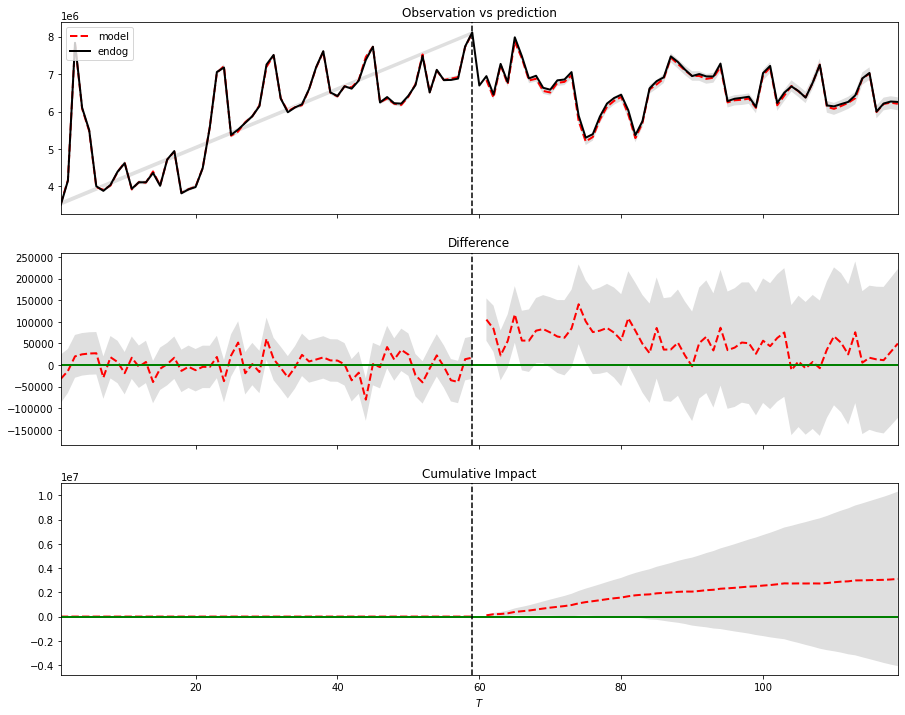

In [4]:
def run_causal_impact(df, baseline_col, intervened_col):
    """Wrangle data to fit causal impact package.
    Run causal impact.
    Return a CausalImpact object, which you can plot() and summary().
    """
    x1 = df[baseline_col] 
    y = df[intervened_col] 
    causal_data = pd.DataFrame(np.array([y, x1]).T, columns=["y","x1"])
    # causal_data.plot();

    pre_period = [0, EXP_DATA['window_length']-1]
    post_period = [EXP_DATA['window_length']+1, len(causal_data)]

    impact = CausalImpact(causal_data, pre_period, post_period)
    impact.run()
    # impact.inferences # table listing model numbers

    return impact


impact = run_causal_impact(mw_df, 'browse_vp_control', 'browse_vp_enabled')

impact.summary()
impact.plot()

                                  Average            Cumulative
Actual                            1013009              59767553
Predicted                         1005557              59327903
95% CI                  [987689, 1023425]  [58273673, 60382132]
                                                               
Absolute Effect                      7451                439650
95% CI                    [25319, -10416]    [1493879, -614579]
                                                               
Relative Effect                      0.7%                  0.7%
95% CI                      [2.5%, -1.0%]         [2.5%, -1.0%]
                                                               
P-value                              0.0%                      
Prob. of Causal Effect             100.0%                      


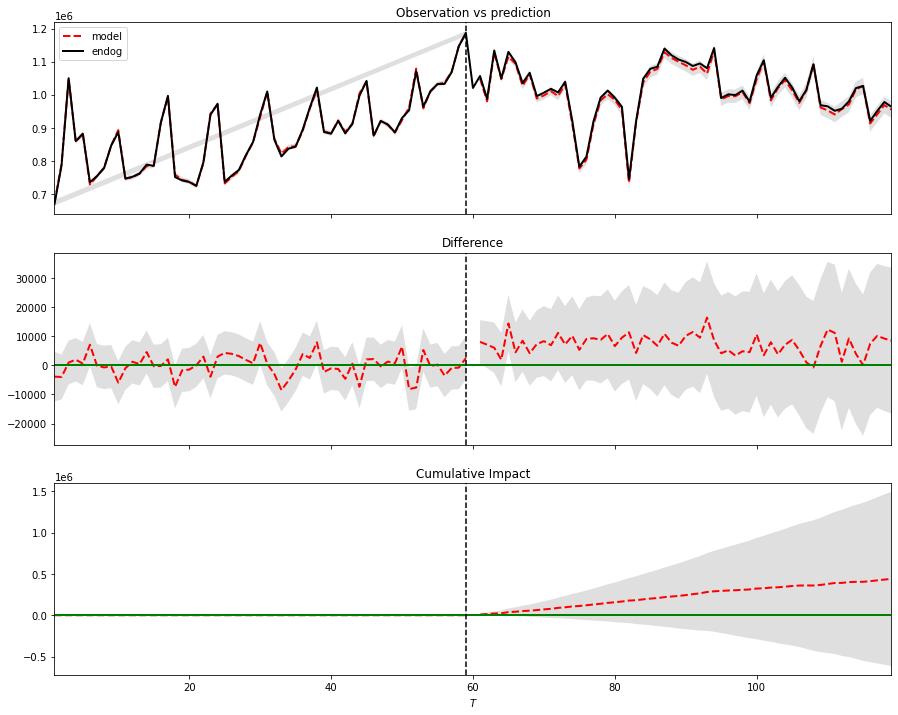

In [7]:
impact = run_causal_impact(mw_df, 'browse_hw_control', 'browse_hw_enabled')

impact.summary()
impact.plot()

                                   Average              Cumulative
Actual                             2021159               119248381
Predicted                          2004739               118279644
95% CI                  [1984114, 2025364]  [117062763, 119496525]
                                                                  
Absolute Effect                      16419                  968736
95% CI                      [37044, -4205]      [2185617, -248144]
                                                                  
Relative Effect                       0.8%                    0.8%
95% CI                       [1.8%, -0.2%]           [1.8%, -0.2%]
                                                                  
P-value                               0.0%                        
Prob. of Causal Effect              100.0%                        


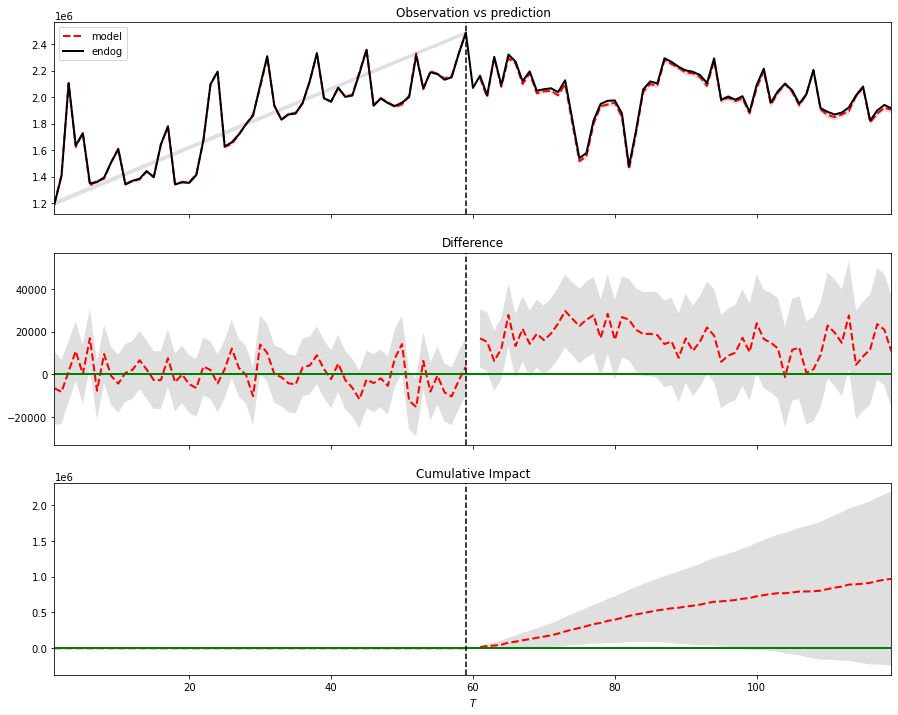

In [7]:
impact = run_causal_impact(mw_df, 'browse_fmp_control', 'browse_fmp_enabled')

impact.summary()
impact.plot()

# Web prowse AB


In [9]:
# web prowse AB
EXP_DATA = {
    'window_length': 90,           # number of days before (or after) launch
    'launch_date': '2020-04-28',   # Prowse AB 100% on 4/23 for LO, and 4/28 for LI.
}


def fetch_data_web(save_locally=True, local_filename='mw_web_prowse.csv'):
    """ Issue SQL and return a pandas df. 
    Read from csv if result is cached locally in that csv. 
    """
    
    if os.path.exists(local_filename):
        df = pd.read_csv(local_filename, index_col=0)
        return df
    
    host = 'localhost' # if bastion, just use whatever is in your ~/.pgpass
    port = '5439'
    db = 'product'
    user = ''
    conn = pg.connect(host=host, port=port, database=db, user=user)
    
    launch_date = EXP_DATA['launch_date']
    window_length = EXP_DATA['window_length']
    
    
    sql = f"""
    with browse as (
    select
      dt,
      sum(case when browse_mw > 0 then 1 else 0 end) as n_users_browse,
      sum(browse_mw) as mw_browse,
      sum(browse_recs_mw) as mw_browse_recs
    from cubes.daily_personalized_browse_metrics
    where dt >= '{launch_date}'::timestamp - interval '{window_length} days'
      and dt < '{launch_date}'::timestamp + interval '{window_length} days'
      and user_id is not null
    group by 1
    )

    , direct_pre  as (
    select
      day as dt,
      user_id,
      sum(minutes_watched_unadjusted) as direct_mw
    from intermediate.minutes_watched
    where dt >= '{launch_date}'::timestamp - interval '{window_length} days'
      and dt < '{launch_date}'::timestamp + interval '{window_length} days'
      and user_id is not null
      and platform = 'web'
      and player = 'site'
      and channel_is_live
      and medium_tracking_code is null
      and minutes_watched_unadjusted > 0
    group by 1,2
    )
    
    , direct as (
    select
      dt,
      sum(1) as n_users_direct,
      sum(direct_mw) as mw_direct
    from direct_pre
    group by 1
    )

    select
      d.dt,
      mw_direct,
      mw_browse,
      mw_browse_recs,
      n_users_browse,
      n_users_direct
    from browse b
    join direct d
      on d.dt = b.dt
    order by 1 
    ;
    """
    
    df = pd.read_sql(sql, conn)
    conn.close()
    
    if save_locally:
        df.to_csv(local_filename)
        
    return df


mw_df = fetch_data_web()
mw_df.head()

,dt,mw_direct,mw_browse,mw_browse_recs,n_users_browse,n_users_direct
0,2020-01-29,225687406,31531256,2471544,584150,2025663
1,2020-01-30,222831855,29607556,2928769,568678,1991316
2,2020-01-31,247681618,33197567,3900262,587741,2075807
3,2020-02-01,261867631,39613037,4378294,664996,2151733
4,2020-02-02,240373066,35359371,3856711,632797,2060962


                                      Average                 Cumulative
Actual                               24169139                 2151053371
Predicted                            40834200                 3634243820
95% CI                    [3521176, 78147223]    [313384714, 6955102926]
                                                                        
Absolute Effect                     -16665061                -1483190449
95% CI                  [20647962, -53978084]  [1837668656, -4804049555]
                                                                        
Relative Effect                        -40.8%                     -40.8%
95% CI                       [50.6%, -132.2%]           [50.6%, -132.2%]
                                                                        
P-value                                  0.0%                           
Prob. of Causal Effect                 100.0%                           


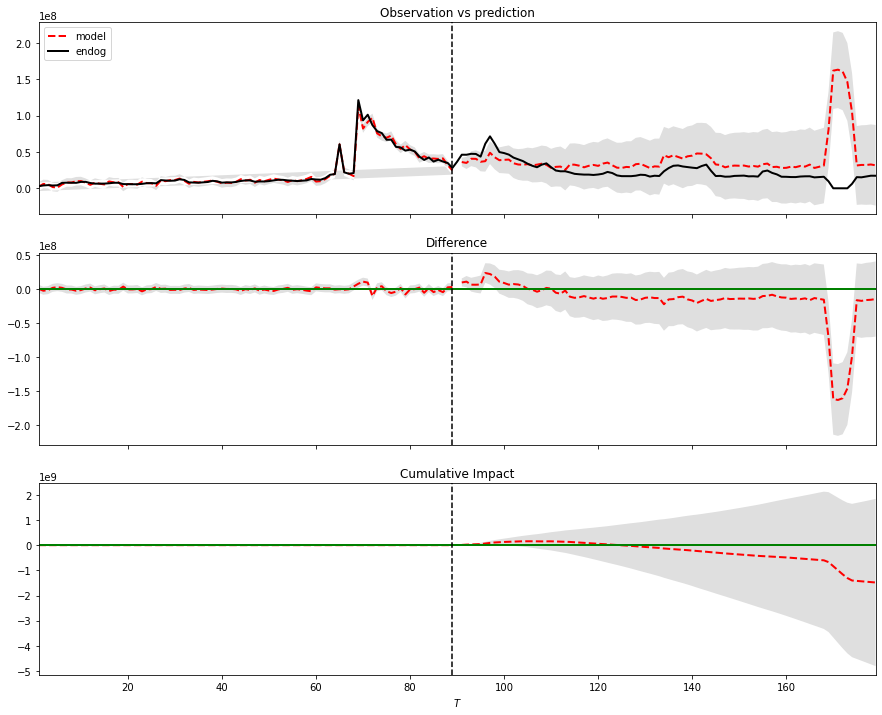

In [10]:
impact = run_causal_impact(mw_df, 'mw_direct', 'mw_browse_recs')

impact.summary()
impact.plot()
# -40.8% relative effect [50.6%, -132.2%] for mw_browse_recs vs direct

                                       Average                 Cumulative
Actual                                46577082                 4145360338
Predicted                             80765355                 7188116598
95% CI                   [10499690, 151031019]   [934472420, 13441760777]
                                                                         
Absolute Effect                      -34188272                -3042756260
95% CI                  [36077392, -104453937]  [3210887917, -9296400439]
                                                                         
Relative Effect                         -42.3%                     -42.3%
95% CI                        [44.7%, -129.3%]           [44.7%, -129.3%]
                                                                         
P-value                                   0.0%                           
Prob. of Causal Effect                  100.0%                           


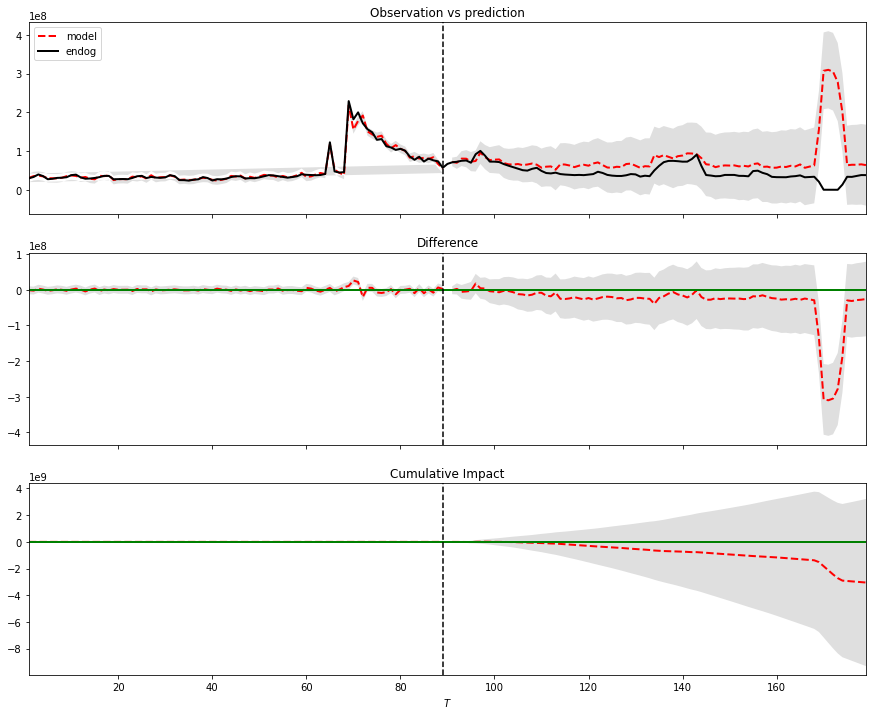

In [11]:
impact = run_causal_impact(mw_df, 'mw_direct', 'mw_browse')

impact.summary()
impact.plot()
# -42.3% relative effect [44.7%, -129.3%] for mw_browse vs direct

                                      Average                 Cumulative
Actual                               24169139                 2151053371
Predicted                            22575888                 2009254096
95% CI                    [5346749, 39805028]    [475860672, 3542647519]
                                                                        
Absolute Effect                       1593250                  141799274
95% CI                  [18822389, -15635889]  [1675192698, -1391594148]
                                                                        
Relative Effect                          7.1%                       7.1%
95% CI                        [83.4%, -69.3%]            [83.4%, -69.3%]
                                                                        
P-value                                  0.0%                           
Prob. of Causal Effect                 100.0%                           


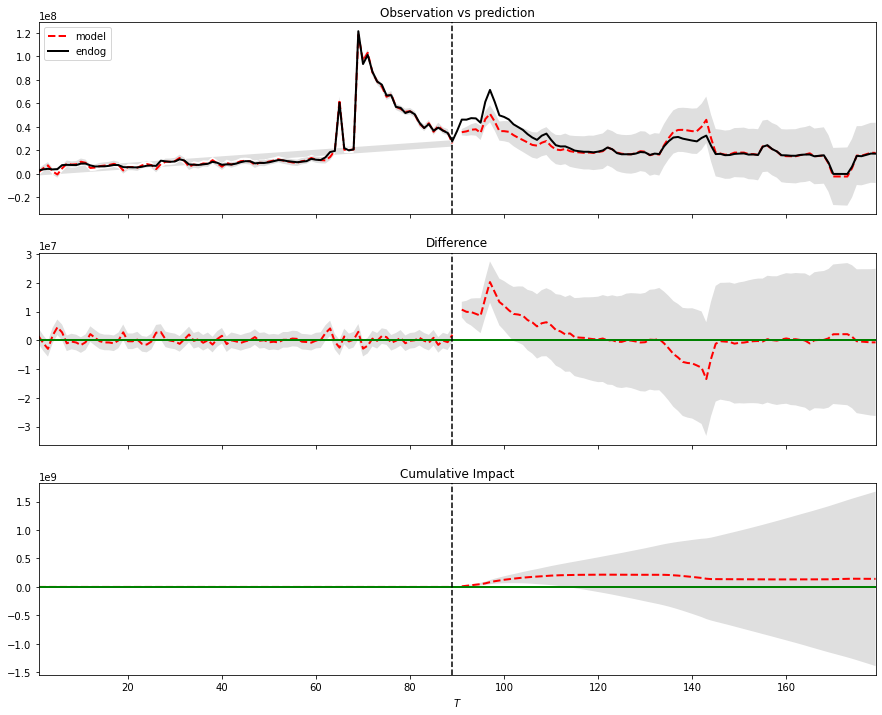

In [12]:
impact = run_causal_impact(mw_df, 'mw_browse', 'mw_browse_recs')

impact.summary()
impact.plot()
# +7.1% relative effect [83.4%, -69.3%] for mw_browse_recs vs mw_browse